# Import

In [1]:
import os
from datetime import datetime
from itertools import chain

import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import nibabel as nib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# DataLoader

In [4]:
class MyDataset(Dataset):
    def __init__(self, test_size=0.2, test=False):
        
        data_files = glob('../../brainmask_nii/*.nii')
        data_files.sort()
        
        test_num = int(test_size * len(data_files))
        train_num = len(data_files) - test_num
        shuffled_index = np.random.permutation(len(data_files))
        
        train_fname = [data_files[i] for i in shuffled_index[:train_num]]
        test_fname  = [data_files[i] for i in shuffled_index[-test_num:]]
        
        label_file = pd.read_csv('../rsc/age_ixi_and_oasis.csv', index_col=0)
        
        if test:
            self.data_files = [data_files[i] for i in shuffled_index[-test_num:]]
            self.label_file = label_file.age_zscored.values[shuffled_index[-test_num:]]
            
        else:
            self.data_files = [data_files[i] for i in shuffled_index[:train_num]]
            self.label_file = label_file.age_zscored.values[shuffled_index[:train_num]]

    def __getitem__(self, idx):
        #print(idx)
        x = torch.tensor(nib.load(self.data_files[idx]).get_fdata())[None, :, :].float() / 255
        y = torch.tensor(self.label_file[idx]).float()
        return x, y

    def __len__(self):
        return len(self.data_files)

train_dset = MyDataset()
test_dset  = MyDataset(test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

# 3D Convolution Model

## Modeling

In [5]:
class Conv3d(nn.Module):
    
    def __init__(self):
        super(Conv3d, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv3d(1, 8, 3, 3),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv3d(8, 16, 3, 3),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
                
        self.layer3 = nn.Sequential(
            nn.Conv3d(16, 32, 3, 3),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [6]:
model = Conv3d().float()
model.to(device)

Conv3d(
  (layer1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(3, 3, 3))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(3, 3, 3))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(3, 3, 3))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=32, o

## Debug

In [7]:
# with torch.no_grad():
#     for i, (x, y)in enumerate(test_loader):
#         if i < 1:
#             x = x.to(device)
#             y = y.to(device)
#             print(model.forward(x), y)
#         else:
#             break

## Passing through Model

In [8]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
loss_fn = nn.MSELoss()

In [9]:
epochs = range(20)

trn_losses, tst_losses = [], []

for e in epochs:
    
    trn_bth_loss = 0
    model.train()
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x).to(device)
        
        loss = loss_fn(y_pred, y)
        del x, y, y_pred

        loss.backward()
        optimizer.step()

        trn_bth_loss += loss.item()
        
        if not i % 20:
            print(f'{i:<4}th Batch. Loss: {loss.item():.3f}')

    torch.cuda.empty_cache()
    trn_losses.append(trn_bth_loss / len(train_loader))
        
        
    tst_bth_loss = 0
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)

            y_pred = model.forward(x).to(device)
            loss = loss_fn(y_pred, y)
            del x, y, y_pred

            tst_bth_loss += loss.item()

    tst_losses.append(tst_bth_loss / len(test_loader))
    torch.cuda.empty_cache()
    
    # Print
    print(f'EPOCHS {e} | TRAIN :: [LOSS] {trn_losses[-1]:.3f} | VALID :: [LOSS] {tst_losses[-1]:.3f}')

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0   th Batch. Loss: 0.340
20  th Batch. Loss: 1.012
40  th Batch. Loss: 1.242
60  th Batch. Loss: 0.419
80  th Batch. Loss: 1.043
100 th Batch. Loss: 0.629


C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


EPOCHS 0 | TRAIN :: [LOSS] 1.029 | VALID :: [LOSS] 1.082
0   th Batch. Loss: 0.405
20  th Batch. Loss: 0.962
40  th Batch. Loss: 1.155
60  th Batch. Loss: 0.410
80  th Batch. Loss: 0.996
100 th Batch. Loss: 0.669
EPOCHS 1 | TRAIN :: [LOSS] 0.997 | VALID :: [LOSS] 1.065
0   th Batch. Loss: 0.386
20  th Batch. Loss: 1.009
40  th Batch. Loss: 1.176
60  th Batch. Loss: 0.430
80  th Batch. Loss: 0.978
100 th Batch. Loss: 0.668
EPOCHS 2 | TRAIN :: [LOSS] 0.986 | VALID :: [LOSS] 1.068
0   th Batch. Loss: 0.388
20  th Batch. Loss: 0.993
40  th Batch. Loss: 1.180
60  th Batch. Loss: 0.411
80  th Batch. Loss: 0.975
100 th Batch. Loss: 0.651
EPOCHS 3 | TRAIN :: [LOSS] 0.983 | VALID :: [LOSS] 1.066
0   th Batch. Loss: 0.395
20  th Batch. Loss: 0.990
40  th Batch. Loss: 1.195
60  th Batch. Loss: 0.420
80  th Batch. Loss: 0.980
100 th Batch. Loss: 0.672
EPOCHS 4 | TRAIN :: [LOSS] 0.979 | VALID :: [LOSS] 1.068
0   th Batch. Loss: 0.381
20  th Batch. Loss: 0.995
40  th Batch. Loss: 1.172
60  th Batch.

# Plot Result

### Loss

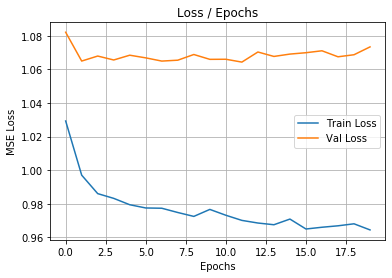

In [10]:
plt.plot(trn_losses)
plt.plot(tst_losses)
plt.legend(['Train Loss', 'Val Loss'])
plt.title('Loss / Epochs')
plt.xlabel('Epochs')
#plt.xticks(np.arange(0, 20, step=2), [x for x in np.arange(0, 20, step=2)])
plt.ylabel('MSE Loss')
plt.grid()
plt.show()

### Regression Accuracy

In [11]:
def plot_result(trues, preds, title='Train', fname=None):
    preds = np.array(list(chain(*preds)))
    trues = np.array(list(chain(*trues)))
    
    cut = max(max(abs(preds)), max(abs(trues)))
    cuts = [-cut, cut]
              
    plt.figure(figsize=(14, 14))
    plt.scatter(preds, trues)
    plt.xlim(*cuts)
    plt.ylim(*cuts)
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title(f'{title} Dataset Prediction')
    plt.grid()
    domain = np.linspace(*cuts, 100)
    plt.plot(domain, domain, c='black')
    if fname:
        plt.savefig(f'./result/{fname}_{title}.png')
    plt.show()

In [12]:
fname = f'{datetime.now().strftime("%Y-%m-%d_%H%M-")}_lr{lr}'

### Train

In [13]:
model.eval()
train_true, train_pred = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(train_loader)):

        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x).to(device)

        train_pred.append(y_pred.to('cpu'))
        train_true.append(y.to('cpu'))

        del x, y, y_pred
        torch.cuda.empty_cache()

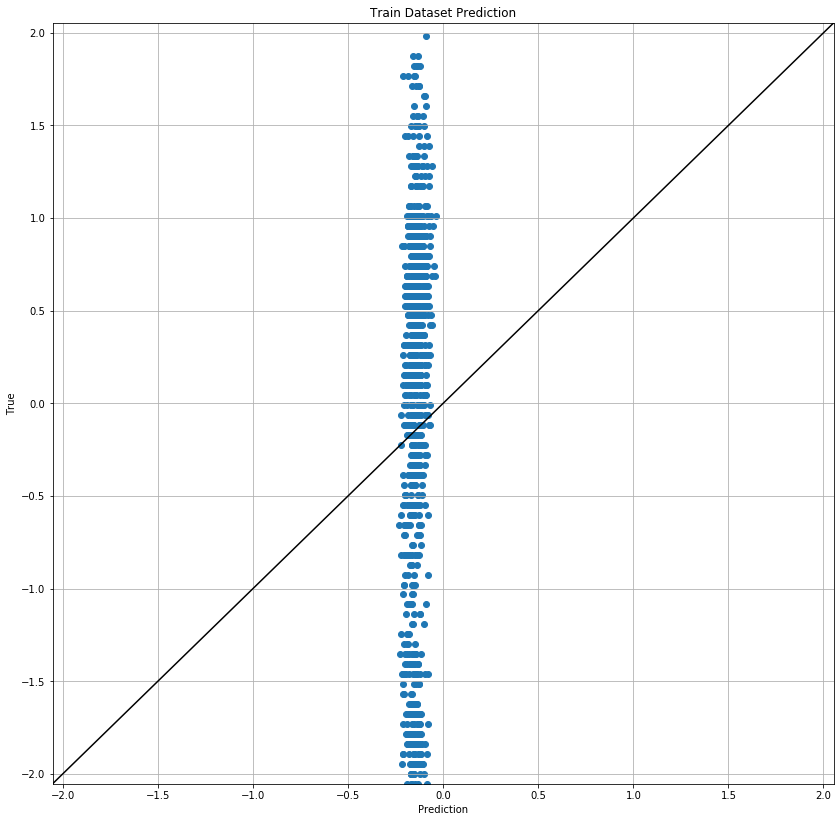

In [14]:
plot_result(train_true, train_pred, fname=fname)

### Test

In [15]:
model.eval()
test_true, test_pred = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(test_loader)):

        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x).to(device)

        test_pred.append(y_pred.to('cpu'))
        test_true.append(y.to('cpu'))

        del x, y, y_pred
        torch.cuda.empty_cache()

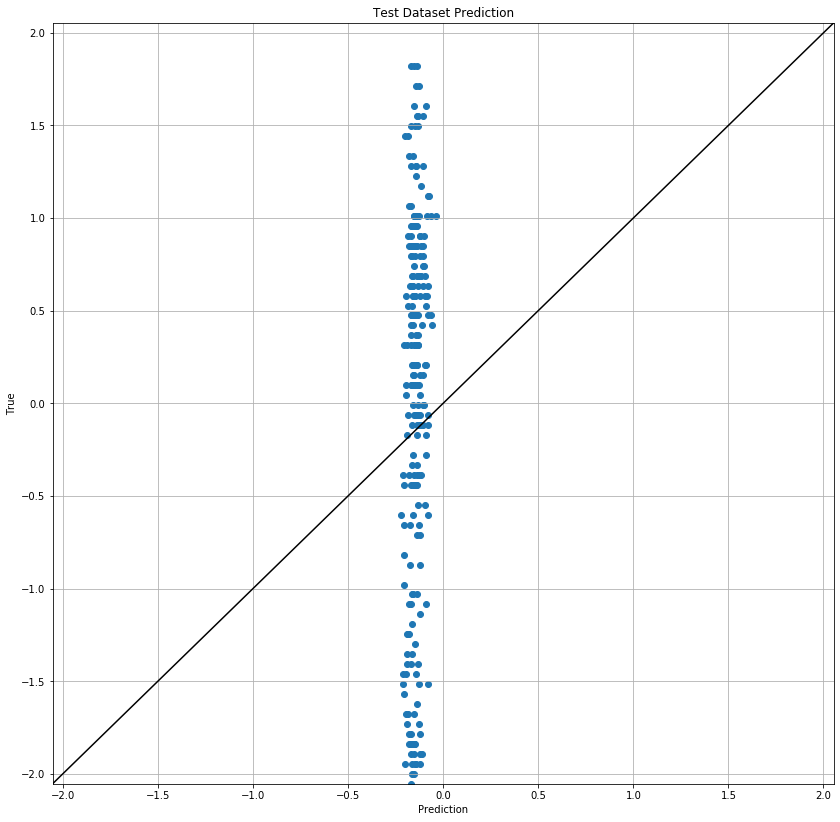

In [16]:
plot_result(test_true, test_pred, title='Test', fname=fname)

## Save Model

In [17]:
torch.save(model, f"./models/{fname}_model.pth")